In [4]:
# Install required packages
# Run in terminal or first time in Jupyter if needed
!pip install yfinance ta imbalanced-learn xgboost -q

In [5]:
import pandas as pd
import numpy as np
import yfinance as yf
import ta
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [6]:
# Download Data
data = yf.download('NIFTYBEES.NS', start='2018-01-01', end='2024-12-31')
if isinstance(data.columns, pd.MultiIndex):
    data.columns = [col[0] for col in data.columns]


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [7]:
# Add Technical Indicators
data['rsi'] = ta.momentum.RSIIndicator(close=data['Close']).rsi()
data['ema'] = ta.trend.EMAIndicator(close=data['Close'], window=14).ema_indicator()
data['macd'] = ta.trend.MACD(close=data['Close']).macd()
data['return'] = data['Close'].pct_change()
data['vol_change'] = data['Volume'].pct_change()
data['bb_width'] = ta.volatility.BollingerBands(close=data['Close']).bollinger_wband()


In [8]:
# Lag Features
data['rsi_lag1'] = data['rsi'].shift(1)
data['macd_lag1'] = data['macd'].shift(1)
data['return_lag1'] = data['return'].shift(1)
data['rsi_lag2'] = data['rsi'].shift(2)
data['macd_lag2'] = data['macd'].shift(2)
data['return_lag2'] = data['return'].shift(2)


In [9]:
# Other Indicators
data['stoch'] = ta.momentum.StochasticOscillator(
    high=data['High'], low=data['Low'], close=data['Close']).stoch()
data['williams_r'] = ta.momentum.WilliamsRIndicator(
    high=data['High'], low=data['Low'], close=data['Close']).williams_r()
data['cci'] = ta.trend.CCIIndicator(
    high=data['High'], low=data['Low'], close=data['Close']).cci()
data['adx'] = ta.trend.ADXIndicator(
    high=data['High'], low=data['Low'], close=data['Close']).adx()

In [10]:
# Step 3: Create Target Variable
data['Target'] = (data['Close'].pct_change().shift(-1) > 0.007).astype(int)
data.dropna(inplace=True)


In [11]:
# Step 4: Feature Selection
features = ['rsi', 'ema', 'macd', 'return', 'vol_change', 'bb_width',
            'rsi_lag1', 'macd_lag1', 'return_lag1',
            'rsi_lag2', 'macd_lag2', 'return_lag2',
            'stoch', 'williams_r', 'cci', 'adx']
X = data[features].astype(float)
y = data['Target'].astype(int)


In [12]:

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False)
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.dropna(inplace=True)
y_train = y_train.loc[X_train.index]


In [13]:

# Step 6: Balance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [14]:
# Step 7: Train XGBoost Model
model = XGBClassifier(n_estimators=200, learning_rate=0.03, max_depth=5,
                      scale_pos_weight=6, subsample=0.8, colsample_bytree=0.8,
                      tree_method='hist', use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_res, y_train_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [16]:
# Step 8: Threshold Tuning
probs = model.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.01, 0.6, 0.01)
f1_scores = []
for t in thresholds:
    preds = (probs > t).astype(int)
    min_len = min(len(y_test), len(preds))
    f1_scores.append(f1_score(y_test[:min_len], preds[:min_len]))
    
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]



In [17]:

# Step 9: Final Evaluation
final_preds = (probs > best_threshold).astype(int)
min_len = min(len(y_test), len(final_preds))
y_test_eval = y_test[:min_len]
final_preds_eval = final_preds[:min_len]


In [18]:

print(f"\nBest Threshold: {best_threshold:.2f}")
print(f"Accuracy: {accuracy_score(y_test_eval, final_preds_eval) * 100:.2f}%")
print(classification_report(y_test_eval, final_preds_eval))



Best Threshold: 0.38
Accuracy: 72.06%
              precision    recall  f1-score   support

           0       0.89      0.77      0.82       290
           1       0.25      0.46      0.33        50

    accuracy                           0.72       340
   macro avg       0.57      0.61      0.57       340
weighted avg       0.80      0.72      0.75       340



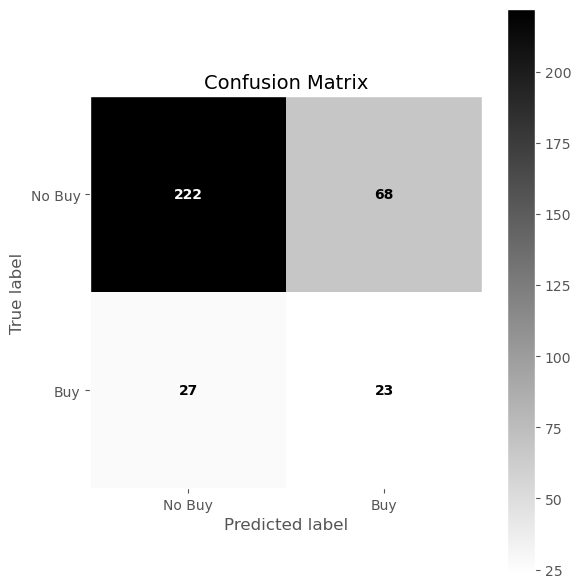

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(y_test_eval, final_preds_eval)

# Plot the confusion matrix with binary colormap (black & white)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Buy", "Buy"])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='binary', ax=ax, colorbar=True)

# Adjust each cell's text color conditionally
max_val = cm.max()
for text in ax.texts:
    val = int(text.get_text())
    # If value is in the darkest cell (e.g. top-left), make text white
    if val > 0.9 * max_val:
        text.set_color("white")
    else:
        text.set_color("black")
    text.set_fontweight("bold")

# Title and labels
plt.title("Confusion Matrix", fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()

In [20]:
data_eval = data.iloc[-len(y_test_eval):].copy()
data_eval = data_eval.iloc[:min_len]
data_eval['Actual_Buy'] = y_test_eval.values
data_eval['Predicted_Buy'] = final_preds_eval

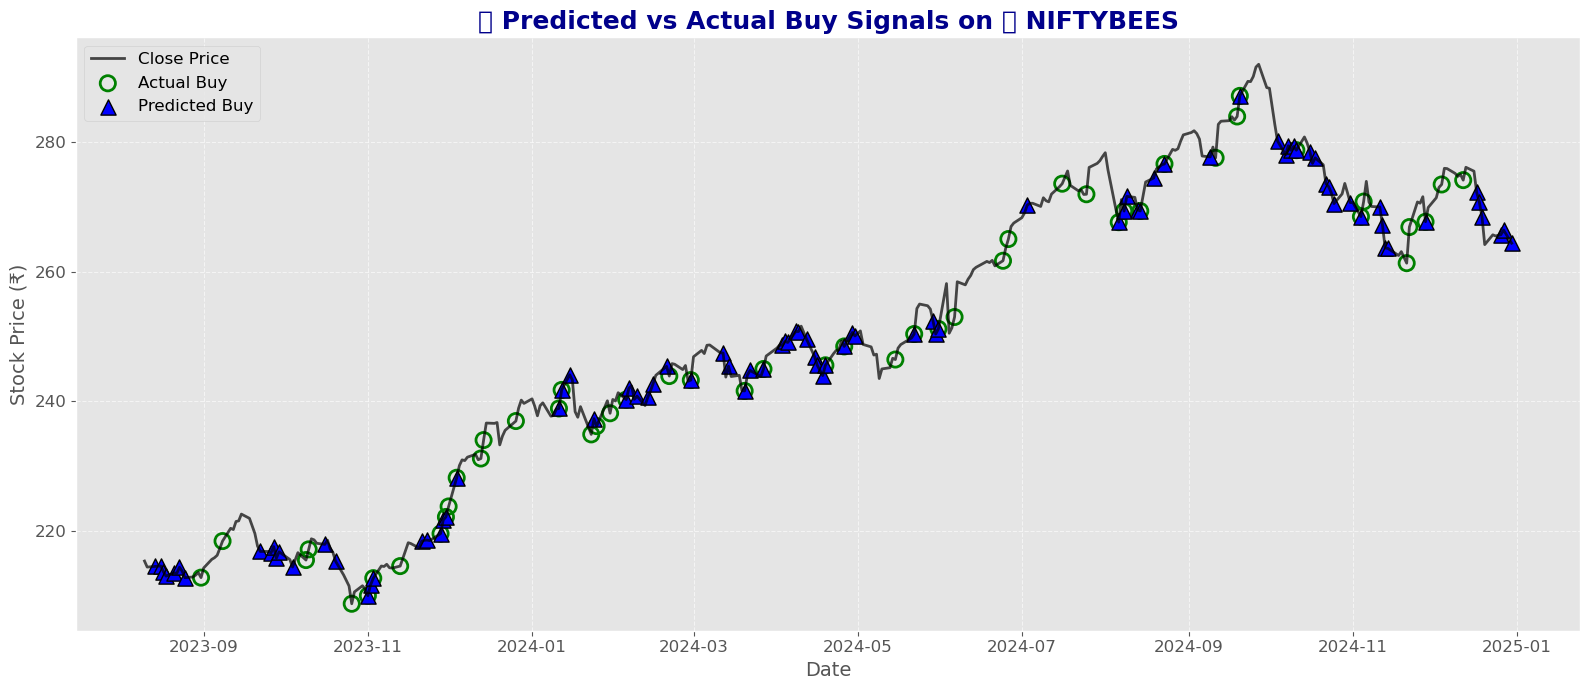

In [21]:
plt.figure(figsize=(16, 7))
plt.style.use('ggplot')  # Simple clean style

# Close price line
plt.plot(data_eval.index, data_eval['Close'], label='Close Price', color='black', linewidth=2, alpha=0.7)

# Actual Buy signals (green hollow circles)
plt.scatter(data_eval.index[data_eval['Actual_Buy'] == 1],
            data_eval['Close'][data_eval['Actual_Buy'] == 1],
            label='Actual Buy',
            facecolors='none', edgecolors='green', marker='o', s=120, linewidths=2)

# Predicted Buy signals (solid blue triangles)
plt.scatter(data_eval.index[data_eval['Predicted_Buy'] == 1],
            data_eval['Close'][data_eval['Predicted_Buy'] == 1],
            label='Predicted Buy',
            facecolors='blue', edgecolors='black', marker='^', s=120, linewidths=1)
# Title and axis styling
plt.title('📈 Predicted vs Actual Buy Signals on 📊 NIFTYBEES', fontsize=18, fontweight='bold', color='darkblue')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Stock Price (₹)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Legend
plt.legend(fontsize=12, loc='upper left')

# Grid and layout
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()